In [1]:
import numpy as np
import pandas as pd

In [2]:
train = pd.read_csv('../Amazon_Review_commons/Dtrain.csv')
test = pd.read_csv('../Amazon_Review_commons/Dtest.csv')

In [3]:
data = pd.concat([train, test], ignore_index=True)

In [4]:
data.drop('index', inplace=True, axis=1)

### 1.1 Creating Tfidf vectorization on the text data for top 2000 words

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [8]:
from nltk.corpus import stopwords

In [9]:
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')

In [10]:
X = tfidf.fit_transform(data.Text)

In [11]:
X.get_shape()

(364118, 2000)

### 1.2 Getting top 2000 words on the Tfidf

In [12]:
N = 2000

In [15]:
features = np.array(tfidf.get_feature_names())
top_2k = features[np.argsort(tfidf.idf_)][::-1][0:N]

In [17]:
top_2k.shape

(2000,)

### 1.3 Calculate co-occurance Matrix

In [18]:
corpus = [each.split() for each in data.Text]

NEIGHBOUR = 5

from collections import defaultdict

from tqdm import tqdm_notebook as tqdm

cooccur = {}

In [19]:
top_2k = list(top_2k)

In [20]:
# O(2000 * 364118 * NEIGHBOUR) 
for current_word in tqdm(top_2k):
    cooccur[current_word] = defaultdict(int)
    for doc in corpus:
        if current_word in doc:
            indx = doc.index(current_word)
            nm = doc[indx-NEIGHBOUR: indx + NEIGHBOUR + 1] # Neighbour Map of the words
    #         for top_word in top_2k:
    #             if top_word != "like" and top_word in nm:
    #                 cooccur["like"][top_word] += 1
            for each_nm in nm:
                if each_nm in top_2k:
                    cooccur[current_word][each_nm] += 1

In [325]:
CM_5k = pd.DataFrame.from_dict(cooccur, orient='index', columns=cooccur.keys())
CM_5k = CM_5k.reindex(labels=cooccur.keys())

In [24]:
CM_2k.fillna(0.0, inplace=True)

In [26]:
CM_2k.head()

regarding  friendly  drawback  tummy  greatest  speak  \
regarding      431.0       0.0       0.0    1.0       0.0    4.0   
friendly         0.0     447.0       0.0    0.0       0.0    0.0   
drawback         0.0       0.0     469.0    0.0       0.0    0.0   
tummy            0.0       0.0       0.0  200.0       0.0    0.0   
greatest         0.0       0.0       0.0    0.0     514.0    0.0   

           international  overpriced  curious  canister  ...   make  little  \
regarding            1.0         0.0      1.0       0.0  ...    0.0     7.0   
friendly             0.0         2.0      0.0       1.0  ...   28.0     2.0   
drawback             1.0         0.0      1.0       0.0  ...    2.0     8.0   
tummy                0.0         0.0      0.0       0.0  ...    2.0    62.0   
greatest             0.0         0.0      0.0       0.0  ...   58.0     3.0   

           flavor  really  product  taste  love  great  good  like  
regarding     2.0     3.0      3.0   32.0   0.0   12.0  22.0   0.0  
friendly     67.0     0.0     69.0   38.0  31.0   83.0   6.0  18.0  
drawback     25.0    10.0     26.0  111.0  12.0   36.0  16.0  13.0  
tummy         4.0    19.0      6.0    4.0   5.0    3.0  33.0   4.0  
greatest     23.0     0.0     53.0   14.0  40.0   43.0   5.0  45.0  

[5 rows x 2000 columns]

In [27]:
CM_2k.to_csv('coocurrance_matrix_2k.csv', index=True)

In [30]:
!ls *.csv

coocurrance_matrix_2k.csv


### 1.4 Truncated SVD

In [31]:
CM_2k = pd.read_csv('coocurrance_matrix_2k.csv')

CM_2k.set_index('Unnamed: 0', inplace=True)

del CM_2k.index.name

In [32]:
CM_2k.head()

regarding  friendly  drawback  tummy  greatest  speak  \
regarding      431.0       0.0       0.0    1.0       0.0    4.0   
friendly         0.0     447.0       0.0    0.0       0.0    0.0   
drawback         0.0       0.0     469.0    0.0       0.0    0.0   
tummy            0.0       0.0       0.0  200.0       0.0    0.0   
greatest         0.0       0.0       0.0    0.0     514.0    0.0   

           international  overpriced  curious  canister  ...   make  little  \
regarding            1.0         0.0      1.0       0.0  ...    0.0     7.0   
friendly             0.0         2.0      0.0       1.0  ...   28.0     2.0   
drawback             1.0         0.0      1.0       0.0  ...    2.0     8.0   
tummy                0.0         0.0      0.0       0.0  ...    2.0    62.0   
greatest             0.0         0.0      0.0       0.0  ...   58.0     3.0   

           flavor  really  product  taste  love  great  good  like  
regarding     2.0     3.0      3.0   32.0   0.0   12.0  22.0   0.0  
friendly     67.0     0.0     69.0   38.0  31.0   83.0   6.0  18.0  
drawback     25.0    10.0     26.0  111.0  12.0   36.0  16.0  13.0  
tummy         4.0    19.0      6.0    4.0   5.0    3.0  33.0   4.0  
greatest     23.0     0.0     53.0   14.0  40.0   43.0   5.0  45.0  

[5 rows x 2000 columns]

In [33]:
CM_2k.shape

(2000, 2000)

In [34]:
from sklearn.decomposition import TruncatedSVD

In [35]:
X = np.array(CM_2k)

In [38]:
svd = TruncatedSVD(n_components=1999, n_iter=10, random_state=42)
svd

TruncatedSVD(algorithm='randomized', n_components=1999, n_iter=10,
       random_state=42, tol=0.0)

In [39]:
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=1999, n_iter=10,
       random_state=42, tol=0.0)

In [45]:
EV = pd.DataFrame(svd.explained_variance_ratio_.cumsum(), 
                     index=range(1, 2000), columns=['explained_variance'])

In [48]:
EV.head()

explained_variance
1            0.208529
2            0.331559
3            0.383854
4            0.421949
5            0.452517

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

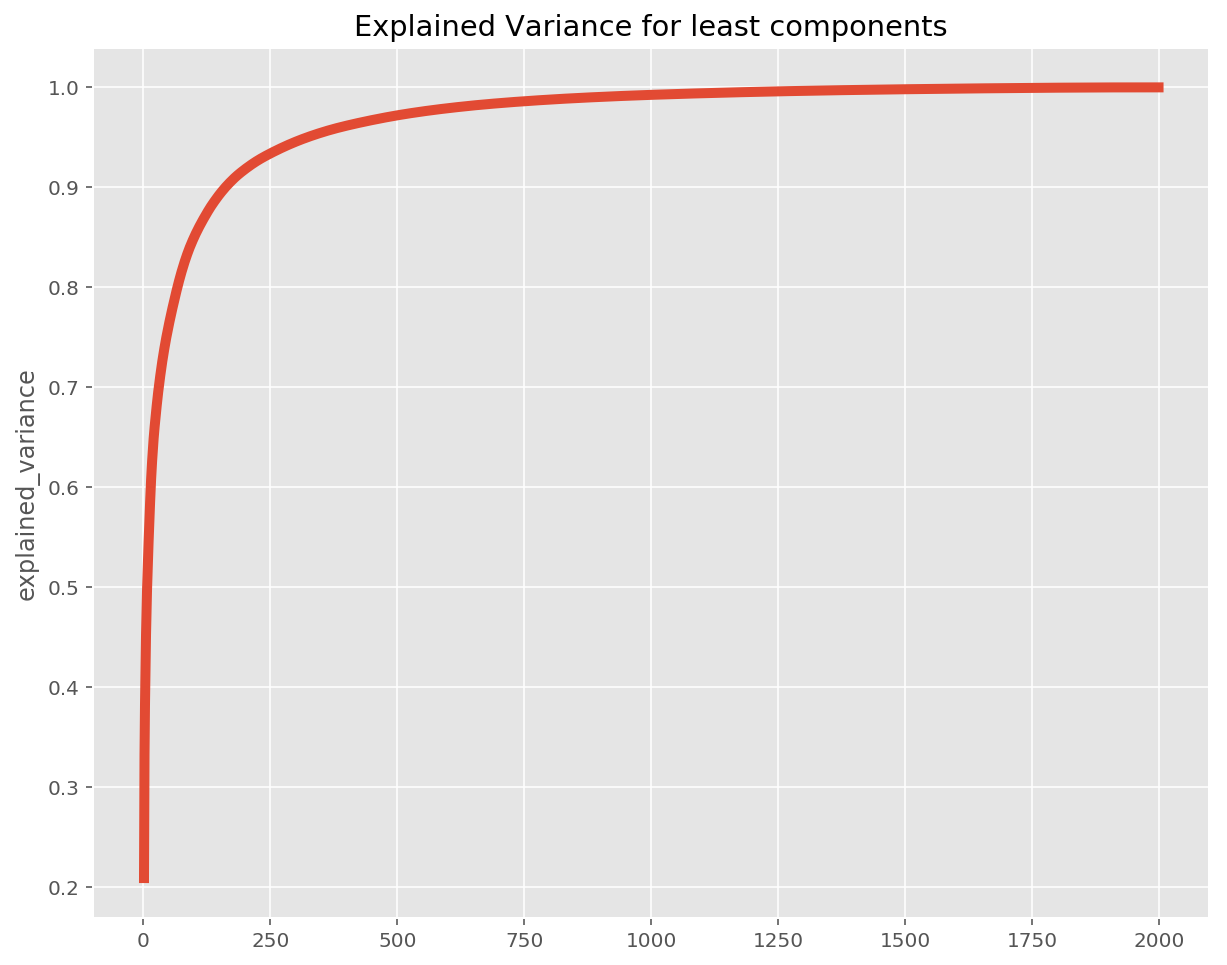

In [56]:
sns.lineplot(data=EV, y="explained_variance", x=EV.index, lw=5);
plt.title('Explained Variance for least components');

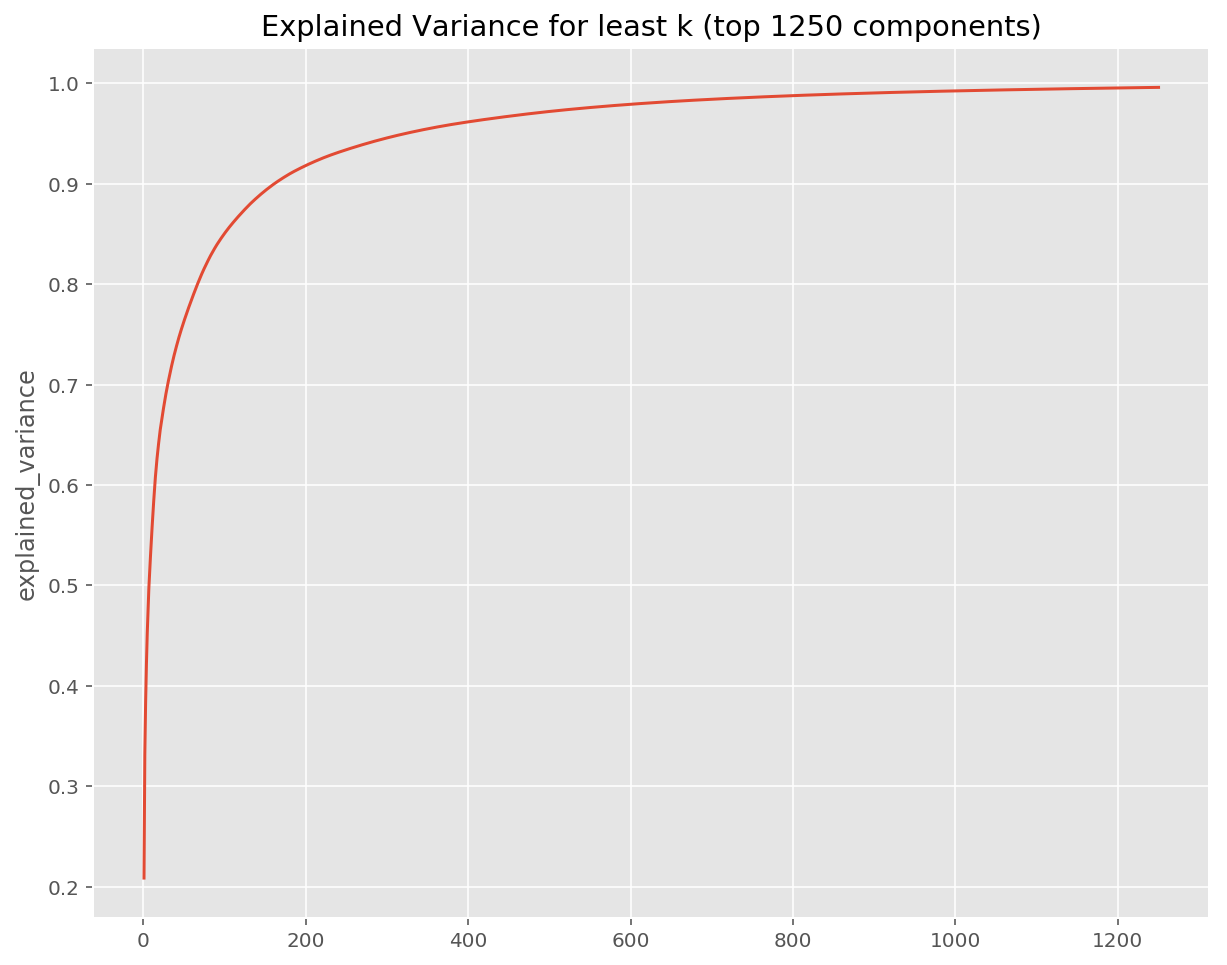

In [57]:
sns.lineplot(data=EV[0:1250], y="explained_variance", x=range(1, 1251));
plt.title('Explained Variance for least k (top 1250 components)');

It seems that the inflection points is around 1250. Hence we take top 1250 components from truncated SVD

In [59]:
X_decomposed = TruncatedSVD(n_components=1250, n_iter=10, random_state=42).fit_transform(X)

In [61]:
X_decomposed.shape

(2000, 1250)

### 1.5 KMeans Clustering

In [62]:
from sklearn.cluster import KMeans

In [66]:
model_performance = []
for n_center in range(2, 100):
    cluster = KMeans(n_clusters=n_center, n_jobs=-1)
    cluster.fit(X_decomposed)
    model_performance.append([n_center, cluster.inertia_])

In [67]:
mp = pd.DataFrame(model_performance, columns=['centers', 'inertia'])

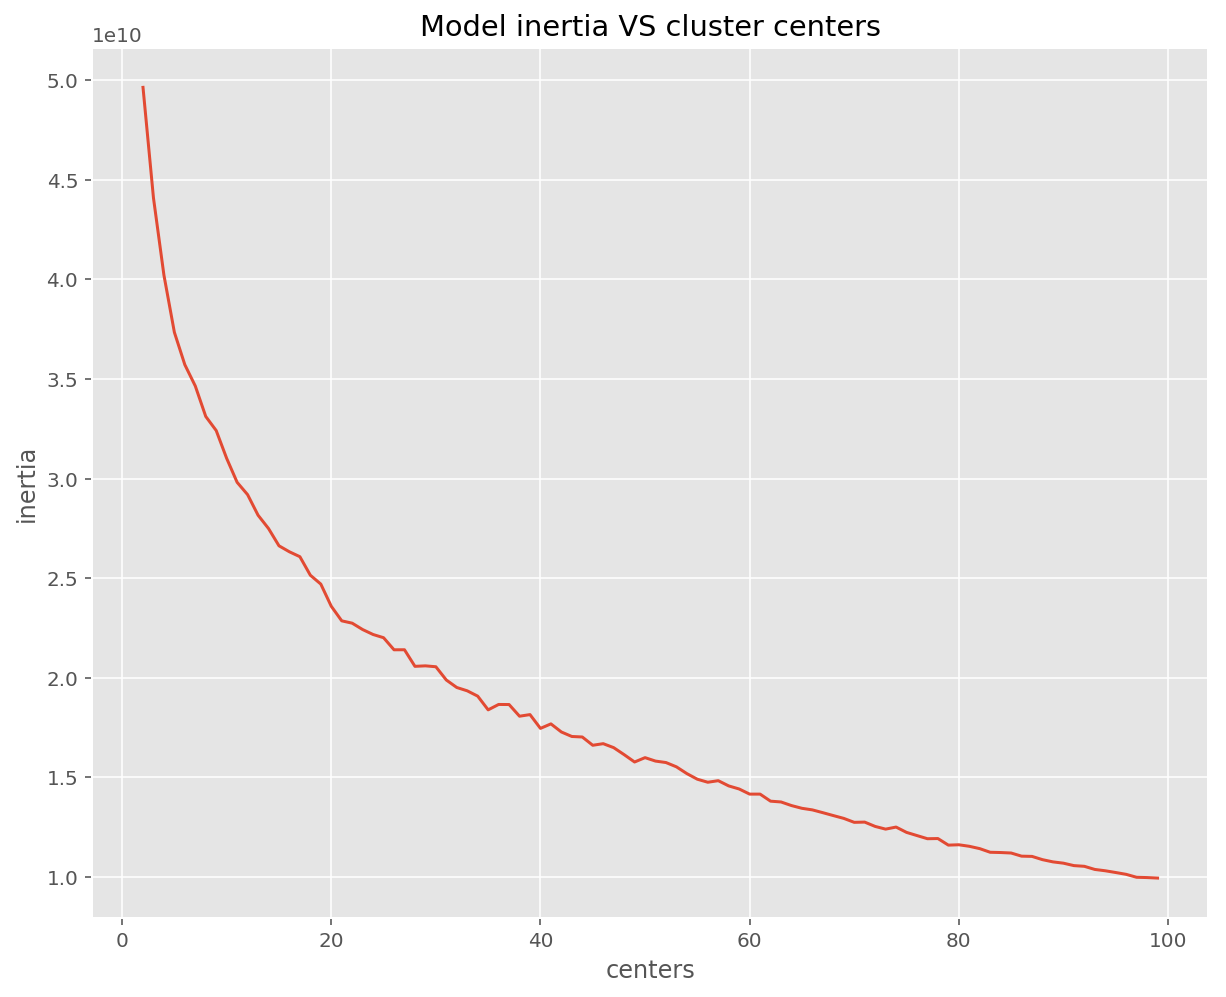

In [68]:
sns.lineplot(data=mp, x='centers', y='inertia');
plt.title('Model inertia VS cluster centers');

We can see that there is no inflection point as it seems. We can hance see outcome of multiple cluster centers.

In [81]:
cluster = KMeans(n_clusters=100, n_jobs=-1)
cluster.fit(X_decomposed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [82]:
labels = cluster.labels_
W2V = pd.DataFrame(X_decomposed)
W2V['word'] = CM_2k.index.values
W2V['clusters'] = labels

In [93]:
W2V.clusters.value_counts().head(4)

29    1584
90     190
12      79
0       31
Name: clusters, dtype: int64

In [87]:
from wordcloud import WordCloud
cluster29_data = W2V[W2V.clusters == 29]
cluster90_data = W2V[W2V.clusters == 90]
cluster12_data = W2V[W2V.clusters == 12]
cluster0_data = W2V[W2V.clusters == 0]

cluster0_corpus = " "
for each in cluster0_data.word.values:
    if each == each:
        each = each.lower()
        cluster0_corpus += each
        cluster0_corpus += ' '

cluster29_corpus = " "
for each in cluster29_data.word.values:
    if each == each:
        each = each.lower()
        cluster29_corpus += each
        cluster29_corpus += ' '

cluster12_corpus = " "
for each in cluster12_data.word.values:
    if each == each:
        each = each.lower()
        cluster12_corpus += each
        cluster12_corpus += ' '

cluster90_corpus = " "
for each in cluster90_data.word.values:
    if each == each:
        each = each.lower()
        cluster90_corpus += each
        cluster90_corpus += ' '

wordcloud1 = WordCloud(max_font_size=40).generate(cluster0_corpus)
wordcloud2 = WordCloud(max_font_size=40).generate(cluster12_corpus)
wordcloud3 = WordCloud(max_font_size=40).generate(cluster29_corpus)
wordcloud4 = WordCloud(max_font_size=40).generate(cluster90_corpus)

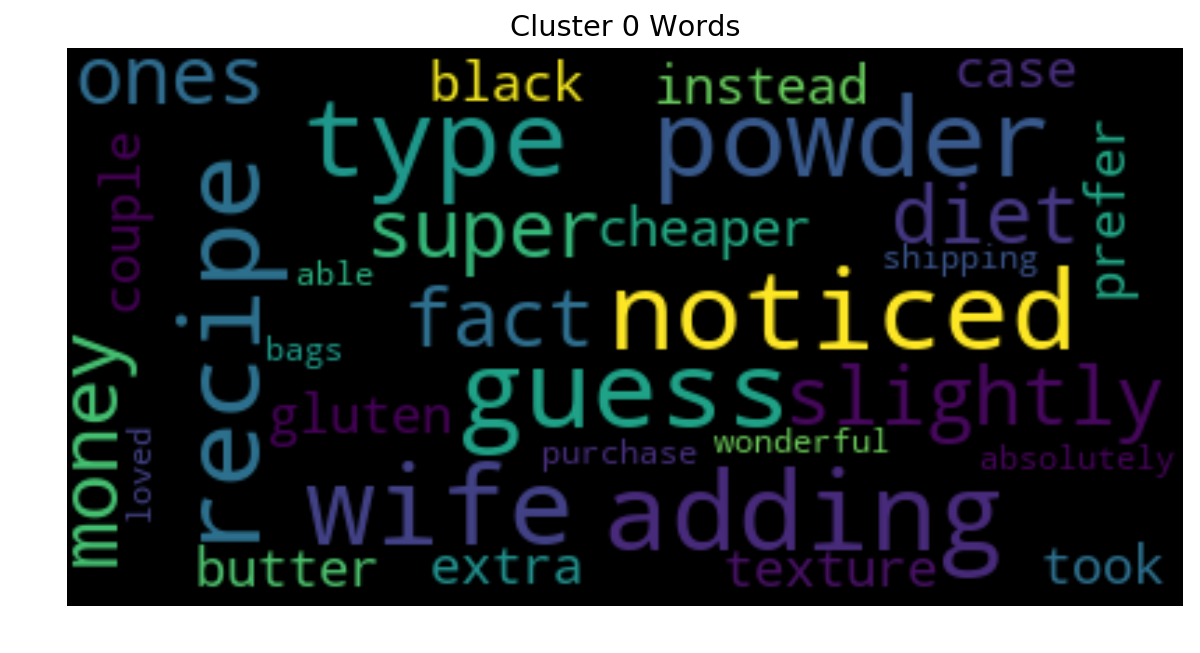

In [88]:
plt.figure()
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Cluster 0 Words')
plt.show()

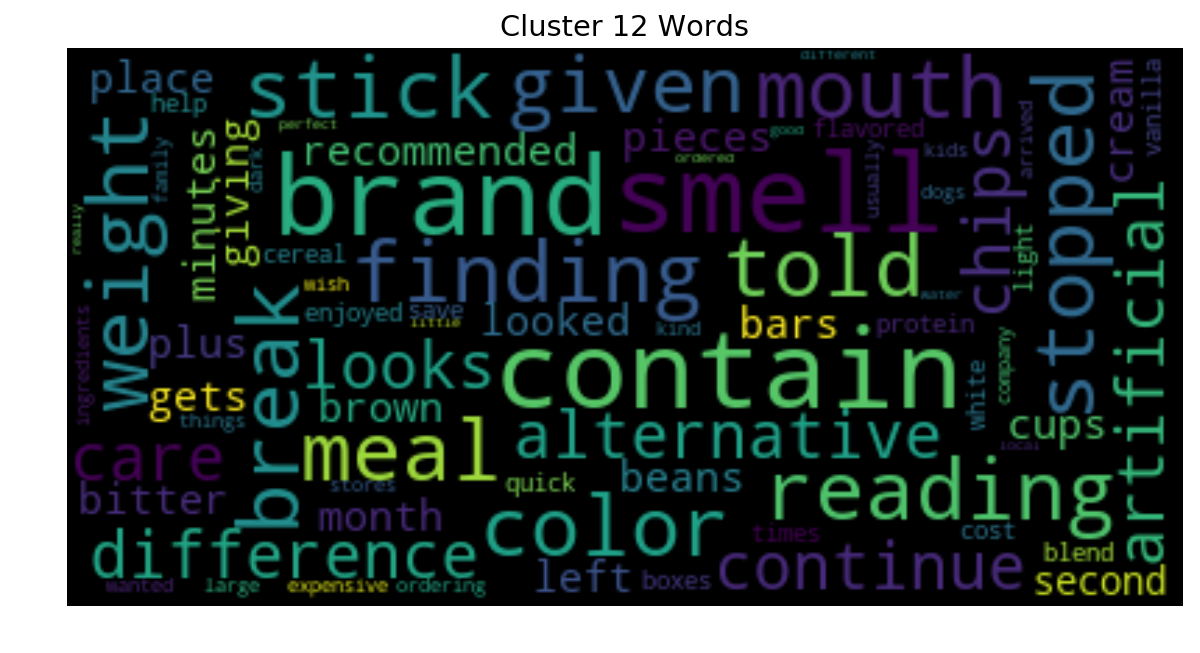

In [89]:
plt.figure()
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.title('Cluster 12 Words')
plt.show()

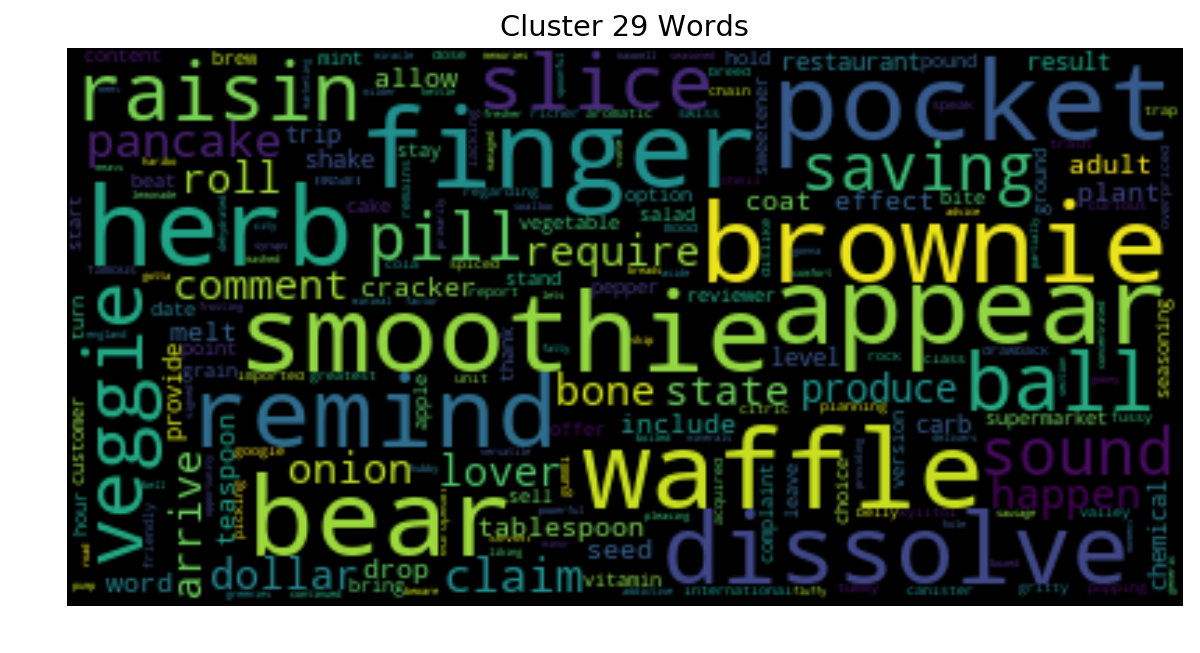

In [90]:
plt.figure()
plt.imshow(wordcloud3, interpolation="bilinear")
plt.axis("off")
plt.title('Cluster 29 Words')
plt.show()

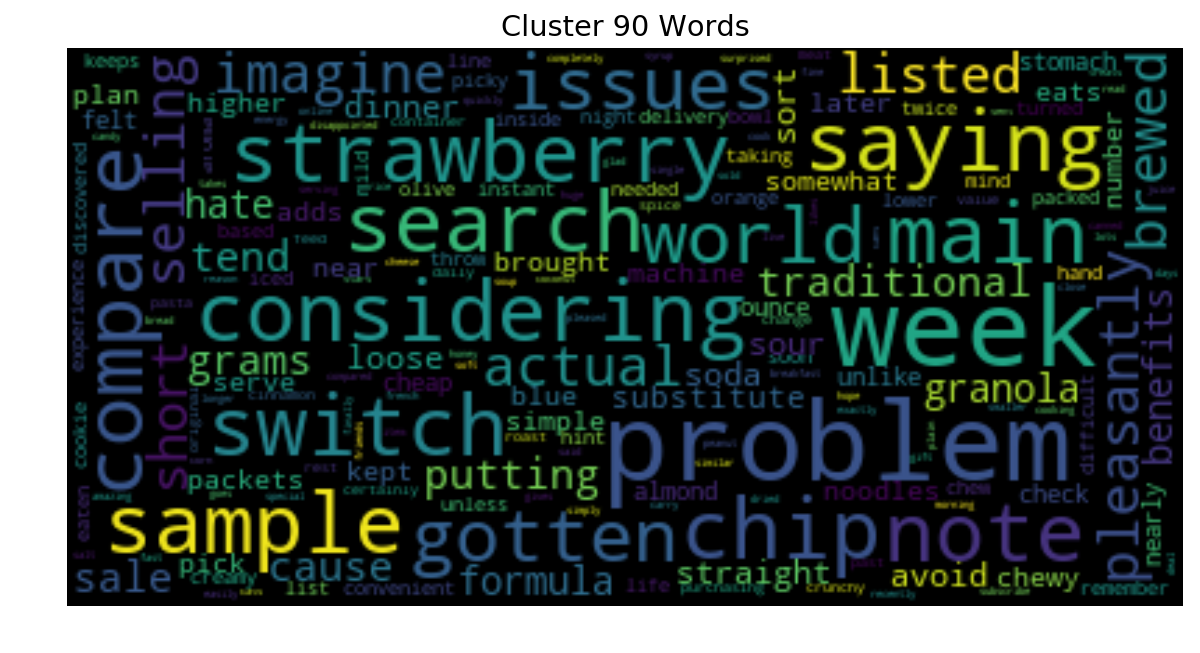

In [91]:
plt.figure()
plt.imshow(wordcloud4, interpolation="bilinear")
plt.axis("off")
plt.title('Cluster 90 Words')
plt.show()

### 1.6 Similarity Function

In [46]:
W2V.drop('clusters', inplace=True, axis=1)

W2V.set_index('word', inplace=True)

del W2V.index.name

In [47]:
from sklearn.metrics.pairwise import cosine_similarity

In [48]:
def n_similar_words(DM, word, n=10):
    """
    Get similar words from the decomposed matrix.
    """
    try:
        word_vector = W2V.loc[word]
    except:
        raise KeyError(f'Word {word} is not found in decomposed matrix')  # Python3.6+ only
    DM = DM[DM.index != word]
    dm = np.array(DM)
    word_vector = np.array(word_vector).reshape(1, -1)
    cs = cosine_similarity(word_vector, dm)
    top_n_index = np.argsort(cs)[0][::-1][0:n]
    scores = np.sort(cs)[0][::-1][0:n]
    top_words = DM.index[top_n_index]
    return dict(zip(top_words, scores))

In [308]:
n_similar_words(W2V, 'chicken') # Sorry Vegan people, love chicken

{'lamb': 0.6806480364858887,
 'fussy': 0.4719368663718736,
 'comfort': 0.46163333231941184,
 'boiled': 0.46035564567809295,
 'pinch': 0.4548344945971061,
 'mushy': 0.4450860550028185,
 'plate': 0.4421742195961542,
 'required': 0.4361432262738079,
 'guys': 0.42086607011893806,
 'balls': 0.4101630183597905}

In [309]:
n_similar_words(W2V, 'pasta') # Who doesn't love pasta!! 

{'spaghetti': 0.8366943029758689,
 'boiled': 0.5621414393289419,
 'mushy': 0.5503219237448416,
 'plate': 0.46952418336512997,
 'stove': 0.46867436994534395,
 'friendly': 0.4595031394666942,
 'comfort': 0.45638033577666615,
 'diagnosed': 0.45403915045748555,
 'imported': 0.4522537044396222,
 'purpose': 0.4339298028918084}

In [313]:
n_similar_words(W2V, 'mexican') # I don't do drugs though ...:)

{'seafood': 0.8577918557460955,
 'labeled': 0.831503585856155,
 'shrimp': 0.8240313839212619,
 'tender': 0.8221888517612491,
 'addicted': 0.8212823256122268,
 'choices': 0.8184803868109307,
 'salads': 0.8155705552408239,
 'guests': 0.813402084680637,
 'marinade': 0.8057959245422462,
 'positive': 0.8055180411155964}

### 2.1 Creating Tfidf vectorization on the text data for top 5000 words

In [314]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

In [315]:
X = tfidf.fit_transform(data.Text)

In [316]:
X.get_shape()

(364118, 5000)

### 2.2 Getting top 5000 words on the Tfidf

In [317]:
N = 5000

In [318]:
features = np.array(tfidf.get_feature_names())
top_5k = features[np.argsort(tfidf.idf_)][::-1][0:N]

In [319]:
top_5k.shape

(5000,)

### 2.3 Calculate co-occurance Matrix

In [323]:
corpus = [each.split() for each in data.Text]
NEIGHBOUR = 5
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
cooccur = {}

In [321]:
top_5k = list(top_5k)

In [324]:
# O(5000 * 364118 * NEIGHBOUR) 
for current_word in tqdm(top_5k):
    cooccur[current_word] = defaultdict(int)
    for doc in corpus:
        if current_word in doc:
            indx = doc.index(current_word)
            nm = doc[indx-NEIGHBOUR: indx + NEIGHBOUR + 1] # Neighbour Map of the words
    #         for top_word in top_5k:
    #             if top_word != "like" and top_word in nm:
    #                 cooccur["like"][top_word] += 1
            for each_nm in nm:
                if each_nm in top_5k:
                    cooccur[current_word][each_nm] += 1

In [22]:
CM_5k = pd.DataFrame.from_dict(cooccur, orient='index', columns=cooccur.keys())

CM_5k = CM_5k.reindex(labels=cooccur.keys())

In [24]:
CM_5k.fillna(0.0, inplace=True)

In [ ]:
CM_5k.head()

In [27]:
CM_5k.to_csv('coocurrance_matrix_5k.csv', index=True)

In [10]:
!ls *.csv

coocurrance_matrix_2k.csv  coocurrance_matrix_5k.csv


### 2.4 Truncated SVD

In [11]:
CM_5k = pd.read_csv('coocurrance_matrix_5k.csv')

CM_5k.set_index('Unnamed: 0', inplace=True)

del CM_5k.index.name

In [12]:
CM_5k.head()

rapidly  periodically  freshen  glutino  overdo  schnauzer  \
rapidly         114.0           0.0      0.0      0.0     0.0        0.0   
periodically      0.0         110.0      0.0      0.0     0.0        0.0   
freshen           0.0           0.0     61.0      0.0     0.0        0.0   
glutino           0.0           0.0      0.0    116.0     0.0        0.0   
overdo            0.0           0.0      0.0      0.0   103.0        0.0   

              join  mouths  annual  john  ...   make  little  flavor  really  \
rapidly        0.0     0.0     0.0   0.0  ...   13.0     1.0     1.0     0.0   
periodically   0.0     0.0     0.0   0.0  ...    1.0     1.0     0.0     1.0   
freshen        0.0     0.0     0.0   0.0  ...    1.0     7.0     5.0    10.0   
glutino        0.0     0.0     0.0   0.0  ...    5.0     4.0     0.0     1.0   
overdo         0.0     0.0     0.0   0.0  ...    0.0    12.0     1.0     3.0   

              product  taste  love  great  good  like  
rapidly           4.0    1.0   9.0    1.0   1.0  35.0  
periodically      1.0    8.0   1.0    2.0   2.0   0.0  
freshen           3.0    0.0   9.0    3.0  13.0   3.0  
glutino           2.0    9.0  17.0    6.0   2.0  47.0  
overdo            0.0    4.0   1.0    2.0  12.0   2.0  

[5 rows x 5000 columns]

In [13]:
CM_5k.shape

(5000, 5000)

In [14]:
from sklearn.decomposition import TruncatedSVD

In [15]:
X = np.array(CM_5k)

In [17]:
svd = TruncatedSVD(n_components=4999, n_iter=10, random_state=42)
svd

TruncatedSVD(algorithm='randomized', n_components=4999, n_iter=10,
       random_state=42, tol=0.0)

In [18]:
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=4999, n_iter=10,
       random_state=42, tol=0.0)

In [19]:
EV = pd.DataFrame(svd.explained_variance_ratio_.cumsum(), 
                     index=range(1, 5000), columns=['explained_variance'])

In [20]:
EV.head()

explained_variance
1            0.215123
2            0.337137
3            0.388887
4            0.426746
5            0.457055

In [21]:
EV.shape

(4999, 1)

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

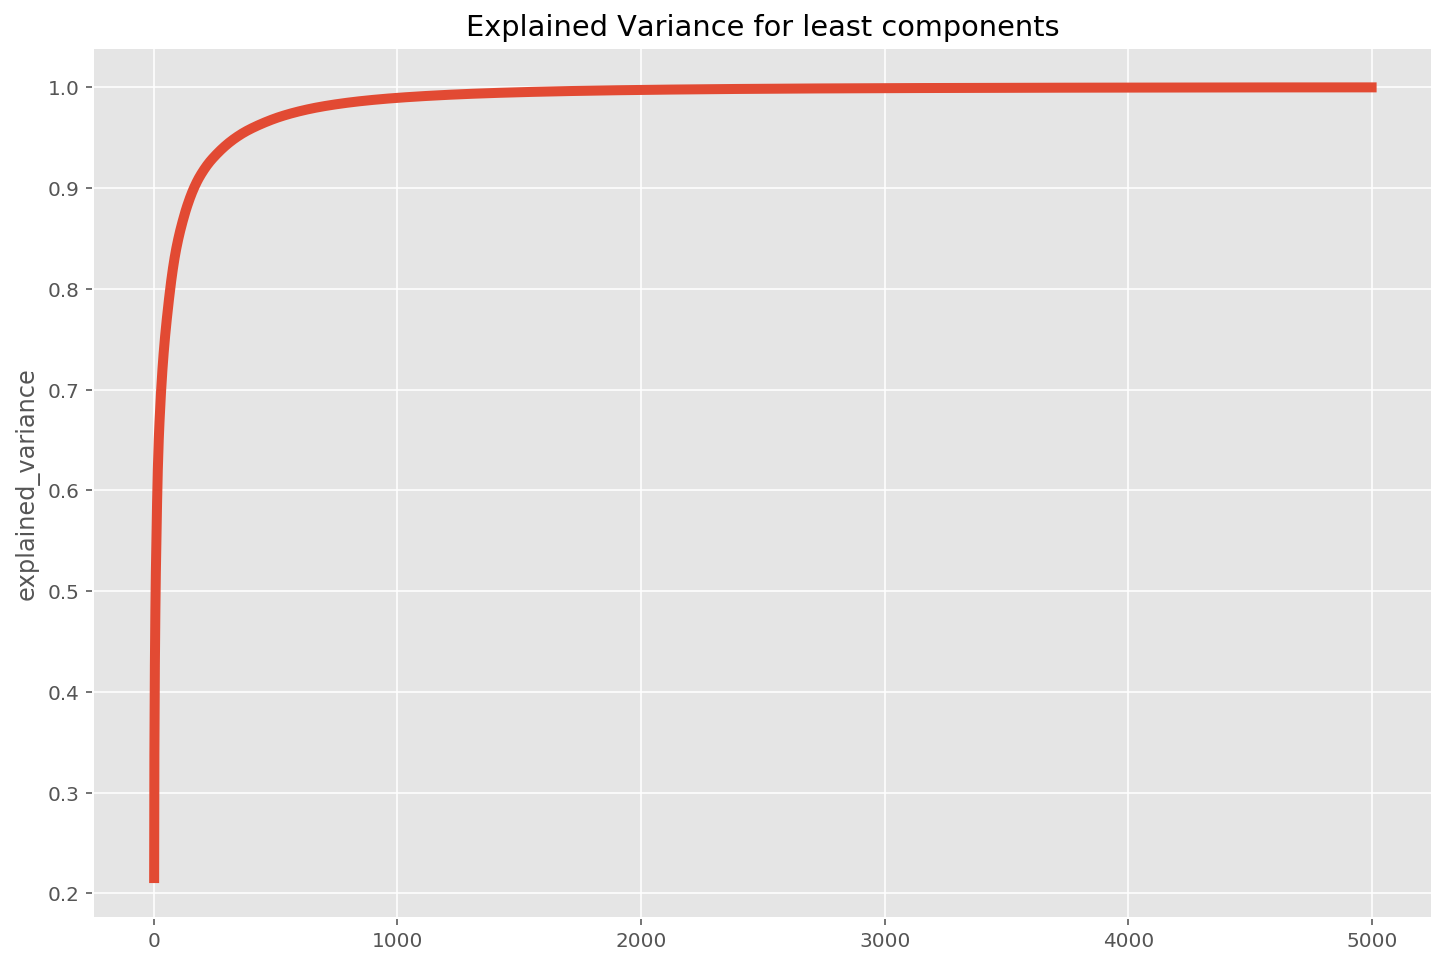

In [25]:
sns.lineplot(data=EV, y="explained_variance", x=EV.index, lw=5);
plt.title('Explained Variance for least components');

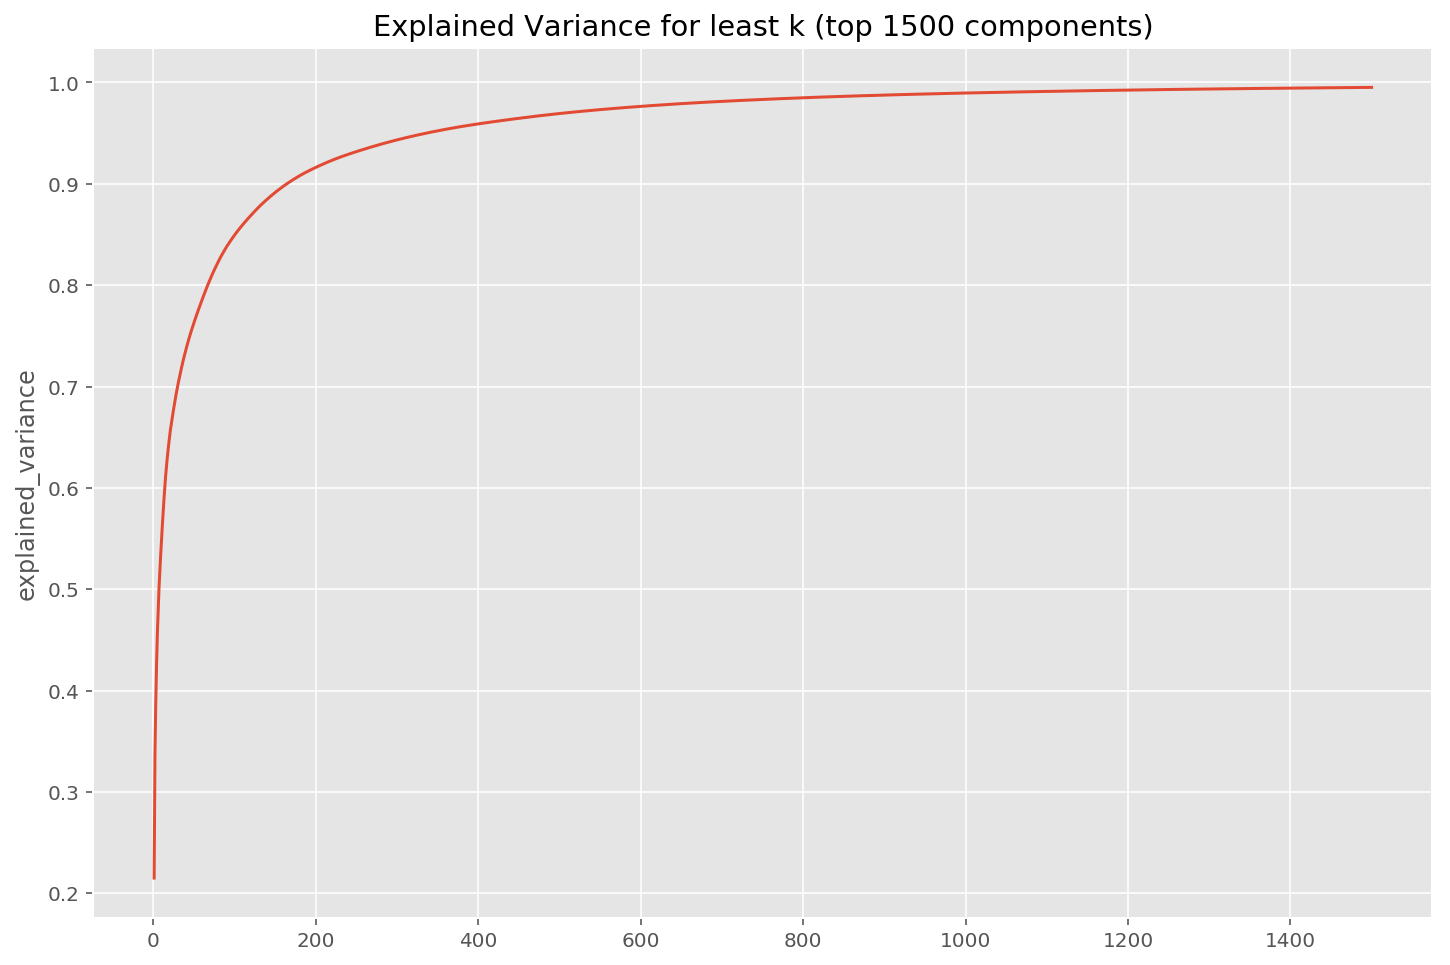

In [26]:
sns.lineplot(data=EV[0:1500], y="explained_variance", x=range(1, 1501));
plt.title('Explained Variance for least k (top 1500 components)');

It seems that the inflection points is around 1500. Hence we take top 1500 components from truncated SVD

In [27]:
X_decomposed = TruncatedSVD(n_components=1500, n_iter=10, random_state=42).fit_transform(X)

In [28]:
X_decomposed.shape

(5000, 1500)

### 2.5 KMeans Clustering

In [29]:
from sklearn.cluster import KMeans

In [30]:
model_performance = []
for n_center in range(2, 100):
    cluster = KMeans(n_clusters=n_center, n_jobs=-1)
    cluster.fit(X_decomposed)
    model_performance.append([n_center, cluster.inertia_])

In [31]:
mp = pd.DataFrame(model_performance, columns=['centers', 'inertia'])

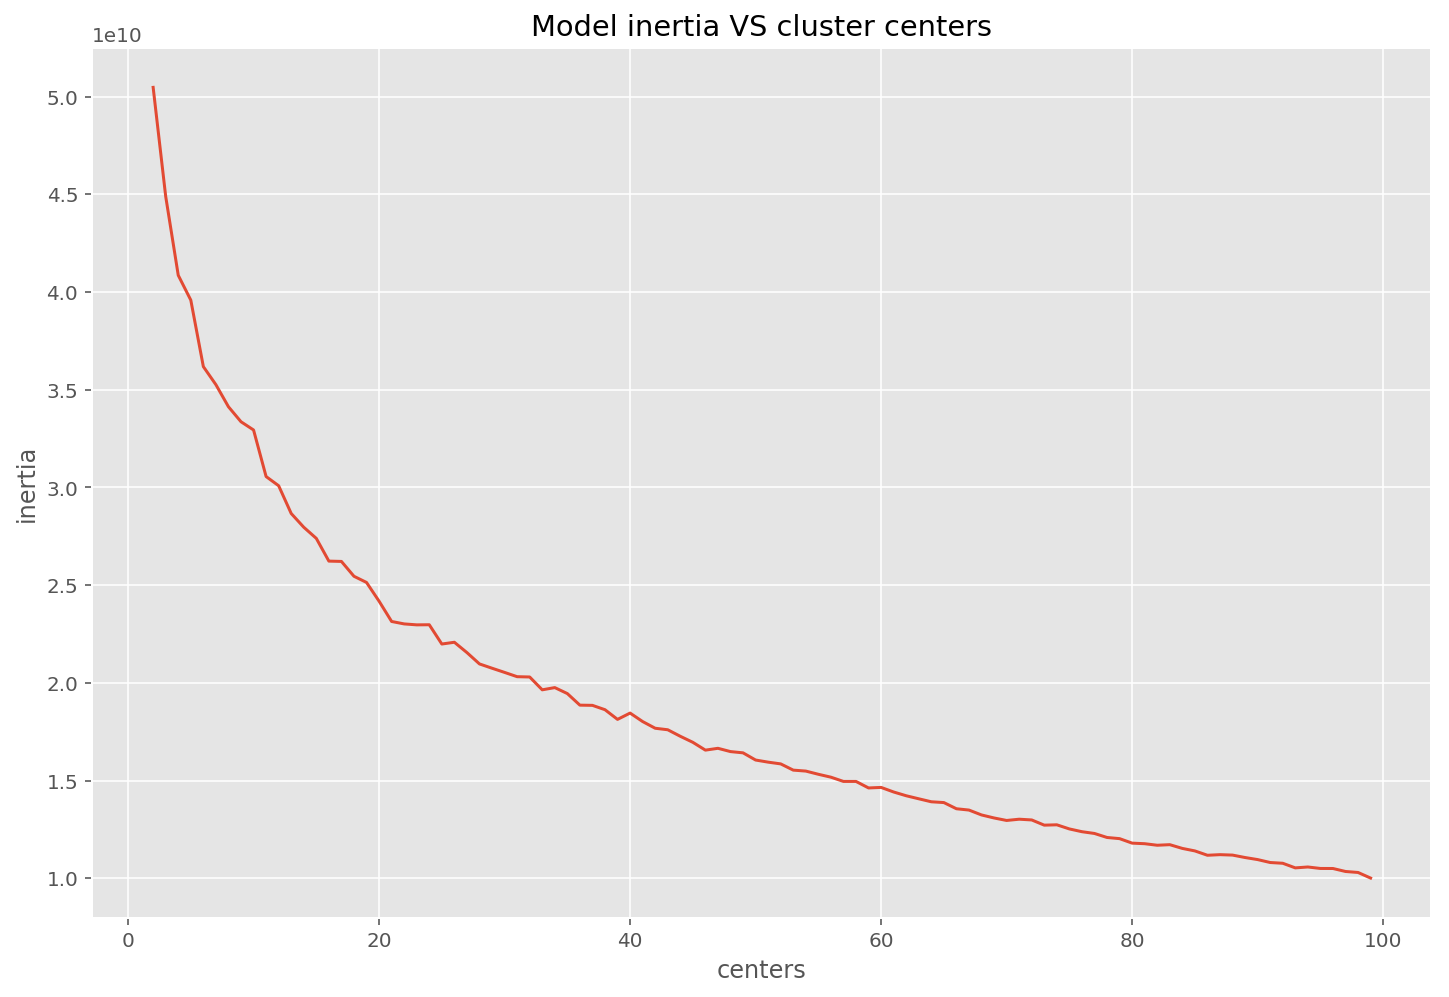

In [32]:
sns.lineplot(data=mp, x='centers', y='inertia');
plt.title('Model inertia VS cluster centers');

We can see that there is no inflection point as it seems. We can hance see outcome of multiple cluster centers.

In [33]:
cluster = KMeans(n_clusters=100, n_jobs=-1)
cluster.fit(X_decomposed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [35]:
labels = cluster.labels_
W2V = pd.DataFrame(X_decomposed)
W2V['word'] = CM_5k.index.values
W2V['clusters'] = labels

In [39]:
W2V.clusters.value_counts().head(5)

3     4438
0      222
93     146
25      75
94      24
Name: clusters, dtype: int64

In [40]:
from wordcloud import WordCloud
cluster3_data = W2V[W2V.clusters == 3]
cluster0_data = W2V[W2V.clusters == 0]
cluster93_data = W2V[W2V.clusters == 93]
cluster25_data = W2V[W2V.clusters == 25]
cluster94_data = W2V[W2V.clusters == 94]

cluster3_corpus = " "
for each in cluster3_data.word.values:
    if each == each:
        each = each.lower()
        cluster3_corpus += each
        cluster3_corpus += ' '

cluster0_corpus = " "
for each in cluster0_data.word.values:
    if each == each:
        each = each.lower()
        cluster0_corpus += each
        cluster0_corpus += ' '

cluster93_corpus = " "
for each in cluster93_data.word.values:
    if each == each:
        each = each.lower()
        cluster93_corpus += each
        cluster93_corpus += ' '

cluster25_corpus = " "
for each in cluster25_data.word.values:
    if each == each:
        each = each.lower()
        cluster25_corpus += each
        cluster25_corpus += ' '

cluster94_corpus = " "
for each in cluster94_data.word.values:
    if each == each:
        each = each.lower()
        cluster94_corpus += each
        cluster94_corpus += ' '

wordcloud1 = WordCloud(max_font_size=40).generate(cluster3_corpus)
wordcloud2 = WordCloud(max_font_size=40).generate(cluster0_corpus)
wordcloud3 = WordCloud(max_font_size=40).generate(cluster93_corpus)
wordcloud4 = WordCloud(max_font_size=40).generate(cluster25_corpus)
wordcloud5 = WordCloud(max_font_size=40).generate(cluster94_corpus)

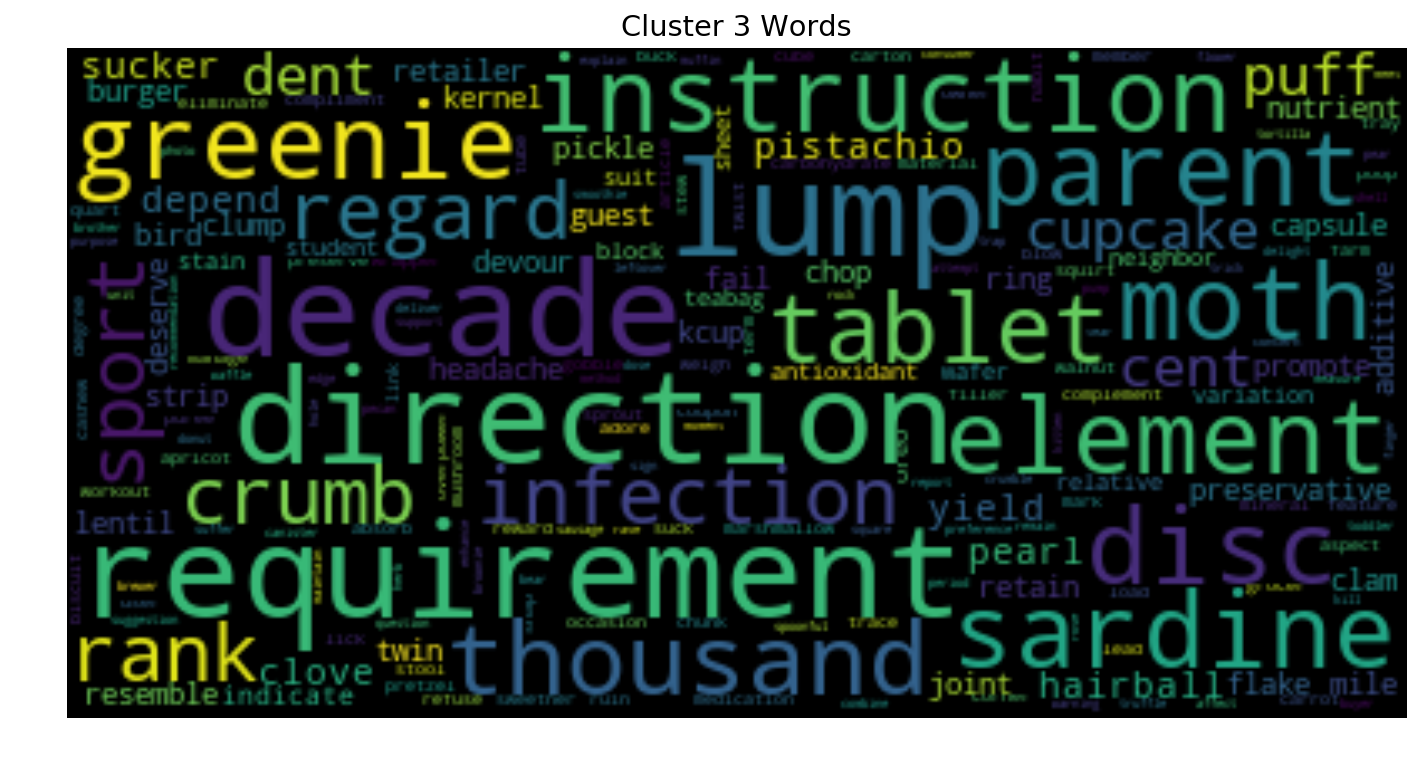

In [41]:
plt.figure()
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Cluster 3 Words')
plt.show()

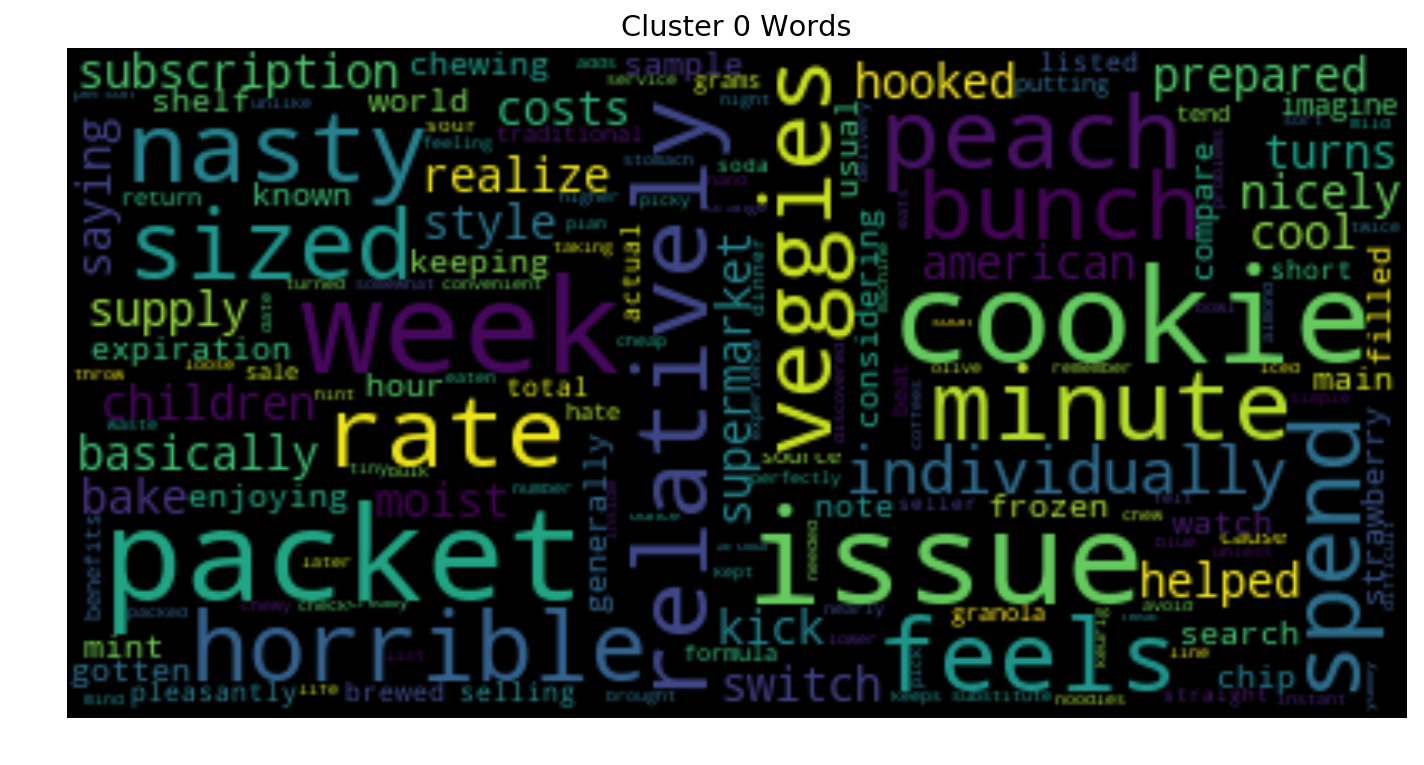

In [42]:
plt.figure()
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.title('Cluster 0 Words')
plt.show()

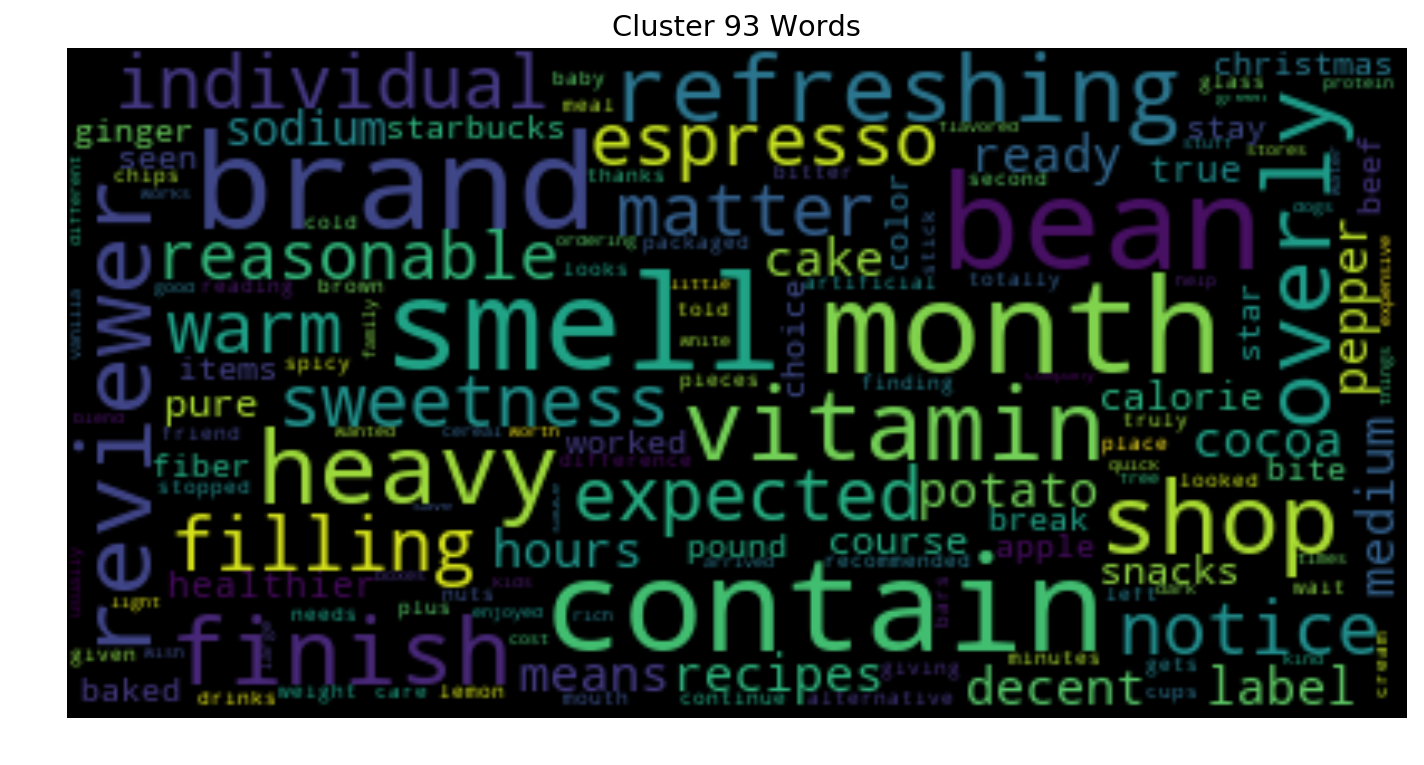

In [43]:
plt.figure()
plt.imshow(wordcloud3, interpolation="bilinear")
plt.axis("off")
plt.title('Cluster 93 Words')
plt.show()

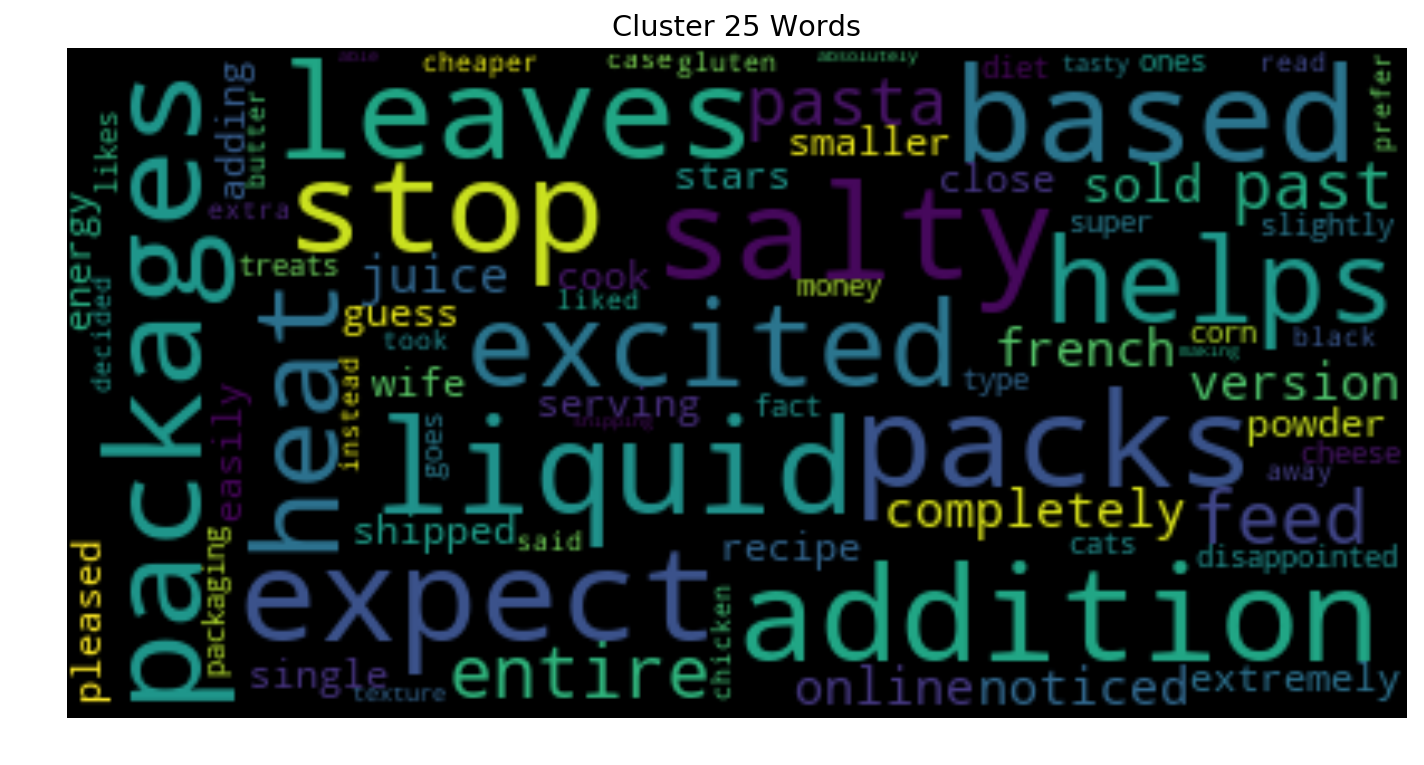

In [44]:
plt.figure()
plt.imshow(wordcloud4, interpolation="bilinear")
plt.axis("off")
plt.title('Cluster 25 Words')
plt.show()

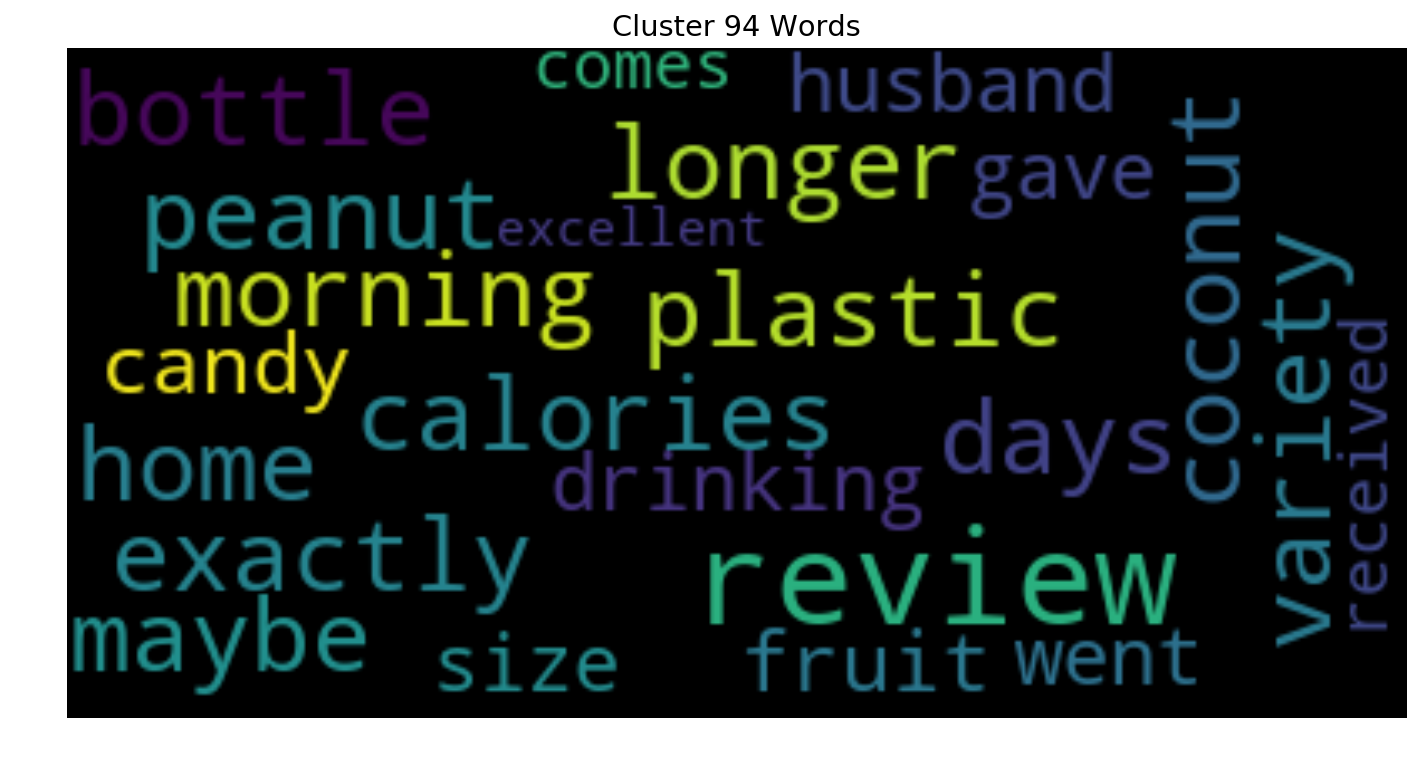

In [45]:
plt.figure()
plt.imshow(wordcloud5, interpolation="bilinear")
plt.axis("off")
plt.title('Cluster 94 Words')
plt.show()

### 2.6 Similarity Function

In [109]:
W2V.drop('clusters', inplace=True, axis=1)

W2V.set_index('word', inplace=True)

del W2V.index.name

In [139]:
from sklearn.metrics.pairwise import cosine_similarity

In [304]:
def n_similar_words(DM, word, n=10):
    """
    Get similar words from the decomposed matrix.
    """
    try:
        word_vector = W2V.loc[word]
    except:
        raise KeyError(f'Word {word} is not found in decomposed matrix')  # Python3.6+ only
    DM = DM[DM.index != word]
    dm = np.array(DM)
    word_vector = np.array(word_vector).reshape(1, -1)
    cs = cosine_similarity(word_vector, dm)
    top_n_index = np.argsort(cs)[0][::-1][0:n]
    scores = np.sort(cs)[0][::-1][0:n]
    top_words = DM.index[top_n_index]
    return dict(zip(top_words, scores))

In [54]:
n_similar_words(W2V, 'coffee') # A lot can happen over a cup of coffee

{'gevalia': 0.9640466792970659,
 'grinds': 0.9527510585368559,
 'donuts': 0.9512167795477176,
 'issimo': 0.9307936963333133,
 'brooklyn': 0.9143895484175677,
 'bolder': 0.8912642856076929,
 'grinding': 0.864907054467531,
 'pero': 0.8595252623292591,
 'nespresso': 0.8562192386505365,
 'brewer': 0.8512085436575973}

- gevalia -- A popular coffee company
- pero -- A cofinated drink
- nespresso -- A coffee machine company to get expresso 
- grinds, brewer, donuts -- Often associated with coffee

In [55]:
n_similar_words(W2V, 'indian') # I am proud to be an Indian

{'masala': 0.5460251937990619,
 'west': 0.540162385723475,
 'ethnic': 0.5200887003232773,
 'saffron': 0.5193594472232994,
 'east': 0.4868488992361084,
 'pale': 0.47319583136379884,
 'warmed': 0.4654923451776196,
 'heavily': 0.4588009080210269,
 'frying': 0.45566671194231534,
 'ketchup': 0.44738861605050273}

In [56]:
n_similar_words(W2V, 'juice') # Health is wealth, but I prefer eating fruit than drinking juice

{'juices': 0.8289394566362553,
 'cranberry': 0.6657897453781265,
 'evaporated': 0.6272447861387266,
 'watermelon': 0.6104141138848042,
 'fortified': 0.6066926911598867,
 'fizzy': 0.575848285880285,
 'mary': 0.5549540099323566,
 'diluted': 0.5394270778309704,
 'smoothie': 0.5183392420554993,
 'pepsi': 0.5032269783866914}